In [ ]:
### Team Name: NobodyExpectsTheSystemIntegration
### Design and Programming by Mojtaba Valipour @ Shiraz University, Udacity 

In [1]:
'''
Resources:
    - https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
    - https://github.com/allanzelener/YAD2K
    - https://github.com/experiencor/basic-yolo-keras/blob/master/Basic%20Yolo%20Keras.ipynb
    - https://github.com/datitran/raccoon_dataset/blob/master/generate_tfrecord.py
    - https://github.com/yhenon/keras-frcnn/blob/master/keras_frcnn/simple_parser.py
    - https://github.com/rykov8/ssd_keras/blob/master/SSD_training.ipynb
    - https://stackoverflow.com/questions/18695605/python-pandas-dataframe-to-dictionary
    - https://www.tensorflow.org
'''
print('Copyright is important @2017')

Copyright is important @2017


In [172]:
import tensorflow as tf
import os
%matplotlib inline
#os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17179998282587194080
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 356188160
locality {
  bus_id: 1
}
incarnation: 12365036179176409972
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:0a:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 394067968
locality {
  bus_id: 1
}
incarnation: 9060433798606903562
physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:09:00.0"
, name: "/gpu:2"
device_type: "GPU"
memory_limit: 396034048
locality {
  bus_id: 1
}
incarnation: 17034801059218985172
physical_device_desc: "device: 2, name: GeForce GTX TITAN X, pci bus id: 0000:06:00.0"
, name: "/gpu:3"
device_type: "GPU"
memory_limit: 395968512
locality {
  bus_id: 1
}
incarnation: 5995413661325090136
physical_device_desc: "device: 3, name: GeForce GTX TITAN X, pci bus id: 0000:05:00.0"
]


# Dataset

In [3]:
# load annotatation of dataset 
dataDir='./Data'
csvLabelFile = '{}/object-dataset/labels.csv'.format(dataDir)
datasetImgsFile = '{}/object-dataset/'.format(dataDir)

In [4]:
# read csv
import pandas as pd
labelsCSV = pd.read_csv(csvLabelFile,names=['filename','xmin','ymin','xmax','ymax','frame','label','previewFrame'],header=None, delimiter=' ')

In [5]:
import numpy as np
print(np.unique(labelsCSV['label']))

['biker' 'car' 'pedestrian' 'trafficLight' 'truck']


In [6]:
labelsCSV['mergeLabel'] = labelsCSV.apply(lambda row: row["label"]+str(row["previewFrame"]) if not pd.isnull(row["previewFrame"]) else row["label"], axis=1) 

In [7]:
x = labelsCSV["mergeLabel"] == 'trafficLightYellow'
labelsCSV.loc[x].head()

,filename,xmin,ymin,xmax,ymax,frame,label,previewFrame,mergeLabel
772,1478020229693065514.jpg,992,518,1016,544,0,trafficLight,Yellow,trafficLightYellow
773,1478020229693065514.jpg,1036,508,1070,542,0,trafficLight,Yellow,trafficLightYellow
785,1478020230199905808.jpg,1006,534,1030,560,0,trafficLight,Yellow,trafficLightYellow
787,1478020230199905808.jpg,1052,514,1086,548,0,trafficLight,Yellow,trafficLightYellow
799,1478020230691664910.jpg,1010,514,1040,538,0,trafficLight,Yellow,trafficLightYellow


In [8]:
# load images
import cv2
import numpy as np
from scipy import misc
def loadImg(imgLoc):
    imageLocation = datasetImgsFile+imgLoc
    image = misc.imread(imageLocation) #cv2.imread(imageLocation) # BGR
    #b,g,r = cv2.split(image)       # get b,g,r
    #image = cv2.merge([r,g,b])     # switch it to rgb

    if (image is None):
        print(imageLocation)
     
    #image = cv2.resize(image, (416,416))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
numSample = 12
centerImgs = np.array([loadImg(imgLoc) for imgLoc in labelsCSV['filename'][0:numSample]])

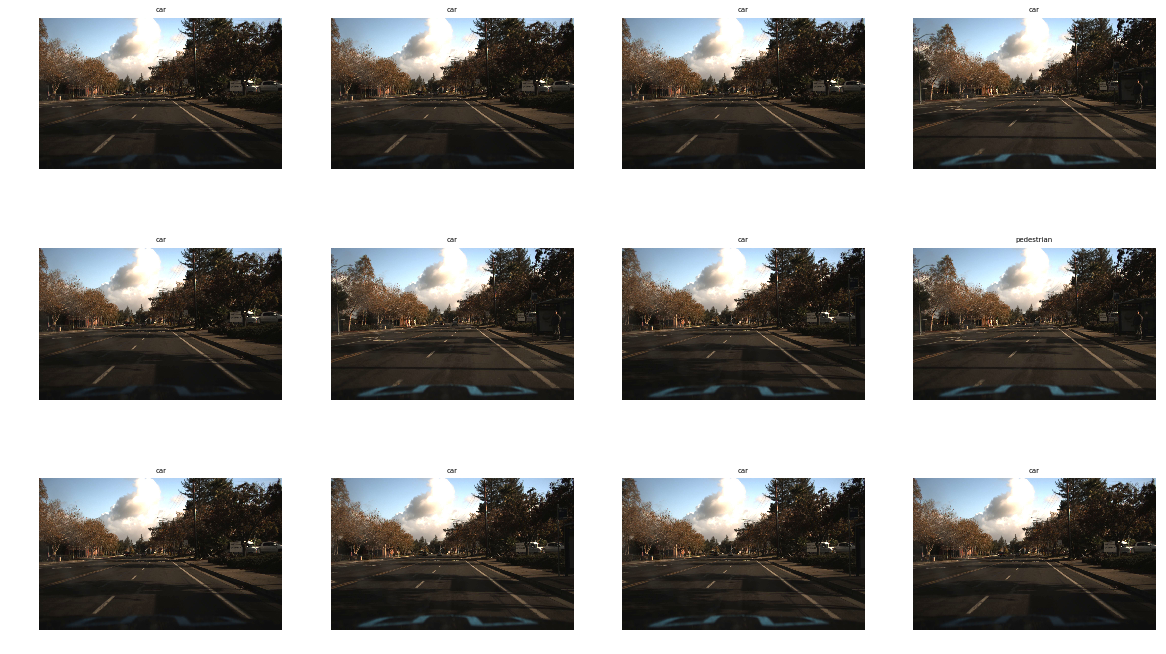

In [173]:
import matplotlib.pyplot as plt
def plotSpecialTool(data,labels,samples2Visualize=12,factors=[2,6], grayFlag=False, thr=0.0):
    # samples2Visualize = 12 # sample 12 random number
    # factors = [2,6] # indicate two factors for number of samples
    assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
    figure = plt.figure(figsize=(20,12))
    nLimit = data.shape[0]
    for i in range(1,samples2Visualize+1):
        img = figure.add_subplot(factors[0],factors[1],i)
        # randomly sample an image from train set
        imgID = np.random.randint(nLimit-1)
        image = data[imgID]
        #image = image[60:150,:]
        if grayFlag:
            plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(image)
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
plotSpecialTool(centerImgs,labelsCSV["label"],factors=[3,4],thr=0.0,grayFlag=False) 

In [10]:
# Ref: https://github.com/yhenon/keras-frcnn/blob/master/keras_frcnn/simple_parser.py
import cv2
import numpy as np

def get_data(input_path):
    found_bg = False
    all_imgs = {}

    classes_count = {}

    class_mapping = {}

    visualise = True

    with open(input_path,'r') as f:

        print('Parsing annotation files')

        for line in f:
            line_split = line.strip().split(' ')
            if len(line_split) == 7:
                (filename,x1,y1,x2,y2,frame,class_name) = line_split
            else:
                (filename,x1,y1,x2,y2,frame,class_name,addClass) = line_split
                class_name = class_name + addClass

            if class_name not in classes_count:
                classes_count[class_name] = 1
            else:
                classes_count[class_name] += 1

            if class_name not in class_mapping:
                if class_name == 'bg' and found_bg == False:
                    print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
                    found_bg = True
                class_mapping[class_name] = len(class_mapping)

            if filename not in all_imgs:
                all_imgs[filename] = {}
                img = cv2.imread(datasetImgsFile + filename)
                (rows,cols) = img.shape[:2]
                all_imgs[filename]['filepath'] = filename
                all_imgs[filename]['width'] = cols
                all_imgs[filename]['height'] = rows
                all_imgs[filename]['bboxes'] = []
                if np.random.randint(0,6) > 0:
                    all_imgs[filename]['imageset'] = 'trainval'
                else:
                    all_imgs[filename]['imageset'] = 'test'

            all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


        all_data = []
        for key in all_imgs:
            all_data.append(all_imgs[key])

        # make sure the bg class is last in the list
        if found_bg:
            if class_mapping['bg'] != len(class_mapping) - 1:
                key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
                val_to_switch = class_mapping['bg']
                class_mapping['bg'] = len(class_mapping) - 1
                class_mapping[key_to_switch] = val_to_switch

        return all_data, classes_count, class_mapping

In [12]:
# load pandas dataframe
import pickle
data = pickle.load( open( "data.p", "rb" ) )
all_data, classes_count, class_mapping = data['all_data'], data['classes_count'], data['class_mapping']

In [13]:
classes_count

{'"biker"': 1676,
 '"car"': 60788,
 '"pedestrian"': 9866,
 '"trafficLight"': 2560,
 '"trafficLight""Green"': 5497,
 '"trafficLight""GreenLeft"': 305,
 '"trafficLight""Red"': 6859,
 '"trafficLight""RedLeft"': 1754,
 '"trafficLight""Yellow"': 264,
 '"trafficLight""YellowLeft"': 14,
 '"truck"': 3503}

In [14]:
train_imgs = [s for s in all_data if s['imageset'] == 'trainval']
val_imgs = [s for s in all_data if s['imageset'] == 'test']

print('Num train samples {}'.format(len(train_imgs)))
print('Num val samples {}'.format(len(val_imgs)))

Num train samples 10928
Num val samples 2135


In [15]:
# convert to records array

In [16]:
labelsCSV2Rec = labelsCSV
labelsCSV2Rec = labelsCSV2Rec.drop('label',1)
labelsCSV2Rec = labelsCSV2Rec.drop('previewFrame',1)
recordArrayDataset = labelsCSV2Rec.to_records(index=False, convert_datetime64=False)

In [17]:
recordArrayDataset

rec.array([('1478019952686311006.jpg',  950, 574, 1004, 620, 0, 'car'),
 ('1478019952686311006.jpg', 1748, 482, 1818, 744, 0, 'pedestrian'),
 ('1478019953180167674.jpg',  872, 586,  926, 632, 0, 'car'), ...,
 ('1478901536960505700.jpg',  146, 604,  246, 692, 1, 'car'),
 ('1478901536960505700.jpg',  710, 582,  800, 618, 0, 'car'),
 ('1478901536960505700.jpg',  896, 546, 1228, 790, 0, 'car')], 
          dtype=[('filename', 'O'), ('xmin', '<i8'), ('ymin', '<i8'), ('xmax', '<i8'), ('ymax', '<i8'), ('frame', '<i8'), ('mergeLabel', 'O')])

# Helper Function 

In [204]:
# Ref: https://github.com/allanzelener/YAD2K
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    if os.path.isfile(anchors_path):
        with open(anchors_path) as f:
            anchors = f.readline()
            anchors = [float(x) for x in anchors.split(',')]
            return np.array(anchors).reshape(-1, 2)
    else:
        Warning("Could not open anchors file, using default.")
        return YOLO_ANCHORS

def process_data(images, boxes=None):
    '''processes the data'''
    images = [PIL.Image.fromarray(i) for i in images]
    orig_size = np.array([images[0].width, images[0].height])
    orig_size = np.expand_dims(orig_size, axis=0)

    # Image preprocessing.
    processed_images = [i.resize((416, 416), PIL.Image.BICUBIC) for i in images]
    processed_images = [np.array(image, dtype=np.float) for image in processed_images]
    processed_images = [image/255. for image in processed_images]

    if boxes is not None:
        # Box preprocessing.
        # Original boxes stored as 1D list of class, x_min, y_min, x_max, y_max.
        boxes = [box.reshape((-1, 5)) for box in boxes]
        # Get extents as y_min, x_min, y_max, x_max, class for comparision with
        # model output.
        boxes_extents = [box[:, [2, 1, 4, 3, 0]] for box in boxes]

        # Get box parameters as x_center, y_center, box_width, box_height, class.
        boxes_xy = [0.5 * (box[:, 3:5] + box[:, 1:3]) for box in boxes]
        boxes_wh = [box[:, 3:5] - box[:, 1:3] for box in boxes]
        boxes_xy = [boxxy / orig_size for boxxy in boxes_xy]
        boxes_wh = [boxwh / orig_size for boxwh in boxes_wh]
        boxes = [np.concatenate((boxes_xy[i], boxes_wh[i], box[:, 0:1]), axis=1) for i, box in enumerate(boxes)]

        # find the max number of boxes
        max_boxes = 0
        for boxz in boxes:
            if boxz.shape[0] > max_boxes:
                max_boxes = boxz.shape[0]

        # add zero pad for training
        for i, boxz in enumerate(boxes):
            if boxz.shape[0]  < max_boxes:
                zero_padding = np.zeros( (max_boxes-boxz.shape[0], 5), dtype=np.float32)
                boxes[i] = np.vstack((boxz, zero_padding))

        return np.array(processed_images), np.array(boxes)
    else:
        return np.array(processed_images)

def get_detector_mask(boxes, anchors):
    '''
    Precompute detectors_mask and matching_true_boxes for training.
    Detectors mask is 1 for each spatial position in the final conv layer and
    anchor that should be active for the given boxes and 0 otherwise.
    Matching true boxes gives the regression targets for the ground truth box
    that caused a detector to be active or 0 otherwise.
    '''
    detectors_mask = [0 for i in range(len(boxes))]
    matching_true_boxes = [0 for i in range(len(boxes))]
    for i, box in enumerate(boxes):
        detectors_mask[i], matching_true_boxes[i] = preprocess_true_boxes(box, anchors, [416, 416])

    return np.array(detectors_mask), np.array(matching_true_boxes)

def create_model(anchors, class_names, load_pretrained=True, freeze_body=True):
    '''
    returns the body of the model and the model

    # Params:

    load_pretrained: whether or not to load the pretrained model or initialize all weights

    freeze_body: whether or not to freeze all weights except for the last layer's

    # Returns:

    model_body: YOLOv2 with new output layer

    model: YOLOv2 with custom loss Lambda layer

    '''

    detectors_mask_shape = (13, 13, 5, 1)
    matching_boxes_shape = (13, 13, 5, 5)

    # Create model input layers.
    image_input = Input(shape=(416, 416, 3))
    boxes_input = Input(shape=(None, 5))
    detectors_mask_input = Input(shape=detectors_mask_shape)
    matching_boxes_input = Input(shape=matching_boxes_shape)

    # Create model body.
    yolo_model = yolo_body(image_input, len(anchors), len(class_names))
    topless_yolo = Model(yolo_model.input, yolo_model.layers[-2].output)

    if load_pretrained:
        # Save topless yolo:
        topless_yolo_path = os.path.join('model_data', 'yolo_topless.h5')
        if not os.path.exists(topless_yolo_path):
            print("CREATING TOPLESS WEIGHTS FILE")
            yolo_path = os.path.join('model_data', 'yolo.h5')
            model_body = load_model(yolo_path)
            model_body = Model(model_body.inputs, model_body.layers[-2].output)
            model_body.save_weights(topless_yolo_path)
        topless_yolo.load_weights(topless_yolo_path)

    if freeze_body:
        for layer in topless_yolo.layers:
            layer.trainable = False
    final_layer = Conv2D(len(anchors)*(5+len(class_names)), (1, 1), activation='linear')(topless_yolo.output)

    model_body = Model(image_input, final_layer)

    # Place model loss on CPU to reduce GPU memory usage.
    with tf.device('/cpu:0'):
        # TODO: Replace Lambda with custom Keras layer for loss.
        model_loss = Lambda(
            yolo_loss,
            output_shape=(1, ),
            name='yolo_loss',
            arguments={'anchors': anchors,
                       'num_classes': len(class_names)})([
                           model_body.output, boxes_input,
                           detectors_mask_input, matching_boxes_input
                       ])

    model = Model(
        [model_body.input, boxes_input, detectors_mask_input,
         matching_boxes_input], model_loss)

    return model_body, model

def draw(model_body, class_names, anchors, image_data, image_set='val',
            weights_name='trained_stage_3_best.h5', out_path="output_images", save_all=True):
    '''
    Draw bounding boxes on image data
    '''
    if image_set == 'train':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data[:int(len(image_data)*.9)]])
    elif image_set == 'val':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data[int(len(image_data)*.9):]])
    elif image_set == 'all':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data])
    else:
        ValueError("draw argument image_set must be 'train', 'val', or 'all'")
    # model.load_weights(weights_name)
    print(image_data.shape)
    model_body.load_weights(weights_name)

    # Create output variables for prediction.
    yolo_outputs = yolo_head(model_body.output, anchors, len(class_names))
    input_image_shape = K.placeholder(shape=(2, ))
    boxes, scores, classes = yolo_eval(
        yolo_outputs, input_image_shape, score_threshold=0.07, iou_threshold=0)

    # Run prediction on overfit image.
    sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.

    if  not os.path.exists(out_path):
        os.makedirs(out_path)
    for i in range(len(image_data)):
        out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                model_body.input: image_data[i],
                input_image_shape: [image_data.shape[2], image_data.shape[3]],
                K.learning_phase(): 0
            })
        print('Found {} boxes for image.'.format(len(out_boxes)))
        print(out_boxes)

        # Plot image with predicted boxes.
        image_with_boxes = draw_boxes(image_data[i][0], out_boxes, out_classes,
                                    class_names, out_scores)
        # Save the image:
        if save_all or (len(out_boxes) > 0):
            image = PIL.Image.fromarray(image_with_boxes)
            image.save(os.path.join(out_path,str(i)+'.png'))

        # To display (pauses the program):
        # plt.imshow(image_with_boxes, interpolation='nearest')
        # plt.show()

In [314]:
# Ref: https://github.com/rykov8/ssd_keras/blob/master/SSD_training.ipynb
class Generator(object):
    def __init__(self, gt,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.],
                 bbox_util = None):
        self.gt = gt
        #self.boxes = boxes
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            rSize = 0
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = np.array(self.gt[key].copy())
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                #y = self.bbox_util.assign_boxes(y)
                inputs.append(img) 
                #print(y)
                targets.append(y)
                rSize += y.shape[0]
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    hSize = y.shape[1]
                    print(targets)
                    #print(targets[0].shape, y.shape)
                    print(np.vstack(targets))
                    tmp_targets = np.vstack(targets).reshape(len(targets),int(rSize/len(targets)),hSize) #np.array(targets)
                    inputs = []
                    targets = []
                    rSize = 0
                    
                    # process image
                    #tmp_inp, tmp_targets = process_data(tmp_inp, tmp_targets)
                    #, detectors_mask, matching_true_boxes
                    #image_data, boxes, detectors_mask, matching_true_boxes],
                    #np.zeros(len(image_data))
                    finalResSize = len(preprocess_input(tmp_inp))
                    yield [preprocess_input(tmp_inp),tmp_targets,detectors_mask,matching_true_boxes,], tmp_targets

In [315]:
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
from keras.applications.imagenet_utils import preprocess_input
gen = Generator(gt, 3, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [316]:
trainGen = gen.generate(True)

In [317]:
tmp = next(trainGen)

[array([[ 410, -629,  528, -513,    2],
       [ 420, -621,  504, -521,    2],
       [ 696, -425,  750, -307,   10],
       [ 696, -429,  758, -307,   10],
       [ 746, -701, 1176, -559,    0],
       [1502, -729, 1918, -525,    0]]), array([[ -583,  -733,  -221,  -457,     0],
       [ -713,  -587,  -673,  -547,     0],
       [ -917,  -599,  -857,  -543,     0],
       [-1063,  -609,  -981,  -533,     0],
       [-1157,  -675, -1057,  -505,     0],
       [-1223,  -699, -1143,  -543,     0],
       [-1375,  -759, -1199,  -487,     0]]), array([[ 172,  394,  208,  450,    4],
       [ 228,  600,  316,  664,    0],
       [ 324,  612,  394,  664,    0],
       [ 328,  612,  396,  658,    0],
       [ 428,  498,  592,  684,    2],
       [ 458,  414,  494,  474,    7],
       [ 668,  612,  884,  754,    0],
       [ 678,  500,  718,  562,    7],
       [ 922,  602,  954,  686,    1],
       [ 972,  586, 1006,  676,    1],
       [ 984,  604, 1022,  688,    1],
       [1008,  608, 1162

ValueError: cannot reshape array of size 145 into shape (3,9,5)

In [277]:
print(tmp[0][1].shape)

(3,)


In [268]:
np.vstack(tmp[0][1]).reshape(3,3,5).shape
#(tmp[0][1]).shape

(3, 3, 5)

In [239]:
print(len(tmp),len(tmp[0]), tmp[0][0].shape, tmp[0][1].shape, tmp[0][2].shape, tmp[0][3].shape)

2 4 (3, 416, 416, 3) (3,) (93086, 13, 13, 5, 1) (93086, 13, 13, 5, 5)


# Model 

In [28]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from yad2k.models.keras_yolo import (preprocess_true_boxes, yolo_body,
                                     yolo_eval, yolo_head, yolo_loss)
from yad2k.utils.draw_boxes import draw_boxes

In [64]:
# Ref: https://github.com/mvpcom/YAD2K/blob/master/retrain_yolo.py

# Args
#data_path = os.path.join('..', 'DATA', 'underwater_data.npz') # path to numpy data file (.npz) containing np.object array 'boxes' and np.uint8 array 'images'
anchors_path = os.path.join('model_data', 'yolo_anchors.txt') # path to numpy data file (.npz) containing np.object array 'boxes' and np.uint8 array 'images'
#classes_path = os.path.join('..', 'DATA', 'underwater_classes.txt') # path to classes file, defaults to pascal_classes.txt

# Default anchor boxes
YOLO_ANCHORS = np.array(
    ((0.57273, 0.677385), (1.87446, 2.06253), (3.33843, 5.47434),
     (7.88282, 3.52778), (9.77052, 9.16828)))


#data_path = os.path.expanduser(data_path)
#classes_path = os.path.expanduser(classes_path)
anchors_path = os.path.expanduser(anchors_path)

#class_names = get_classes(classes_path)
class_names = list(np.unique(labelsCSV['mergeLabel']))
anchors = get_anchors(anchors_path)

In [65]:
class_names

['biker',
 'car',
 'pedestrian',
 'trafficLight',
 'trafficLightGreen',
 'trafficLightGreenLeft',
 'trafficLightRed',
 'trafficLightRedLeft',
 'trafficLightYellow',
 'trafficLightYellowLeft',
 'truck']

In [31]:
 labelsCSV.head()

,filename,xmin,ymin,xmax,ymax,frame,label,previewFrame,mergeLabel,classes
0,1478019952686311006.jpg,950,574,1004,620,0,car,NaN,car,0
1,1478019952686311006.jpg,1748,482,1818,744,0,pedestrian,NaN,pedestrian,1
2,1478019953180167674.jpg,872,586,926,632,0,car,NaN,car,0
3,1478019953689774621.jpg,686,566,728,618,1,truck,NaN,truck,2
4,1478019953689774621.jpg,716,578,764,622,0,car,NaN,car,0


In [32]:
columnLabels = pd.factorize( labelsCSV['mergeLabel'] )[0] # convert from categorical to numerical

In [33]:
np.unique(columnLabels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [34]:
labelsCSV['classes'] = columnLabels

In [35]:
 labelsCSV.head()

,filename,xmin,ymin,xmax,ymax,frame,label,previewFrame,mergeLabel,classes
0,1478019952686311006.jpg,950,574,1004,620,0,car,NaN,car,0
1,1478019952686311006.jpg,1748,482,1818,744,0,pedestrian,NaN,pedestrian,1
2,1478019953180167674.jpg,872,586,926,632,0,car,NaN,car,0
3,1478019953689774621.jpg,686,566,728,618,1,truck,NaN,truck,2
4,1478019953689774621.jpg,716,578,764,622,0,car,NaN,car,0


In [123]:
#data = np.load(data_path) # custom data saved as a numpy file.
#  has 2 arrays: an object array 'boxes' (variable length of boxes in each image)
#  and an array of images 'images'
numSample = 10
image_data = np.array([loadImg(imgLoc) for imgLoc in labelsCSV['filename'][0:numSample]])
boxes =  labelsCSV[['classes','xmin','ymin','xmax','ymax']][0:numSample]

In [124]:
images = [PIL.Image.fromarray(i) for i in image_data]
orig_size = np.array([images[0].width, images[0].height])
orig_size = np.expand_dims(orig_size, axis=0)

In [162]:
def process_boxes(boxes, orig_size=(1920,1200)):
    '''processes the boxes'''
    
    # Box preprocessing.
    # Original boxes stored as 1D list of class, x_min, y_min, x_max, y_max.
    boxes = [box.reshape((-1, 5)) for box in boxes]
    # Get extents as y_min, x_min, y_max, x_max, class for comparision with
    # model output.
    boxes_extents = [box[:, [2, 1, 4, 3, 0]] for box in boxes]

    # Get box parameters as x_center, y_center, box_width, box_height, class.
    boxes_xy = [0.5 * (box[:, 3:5] + box[:, 1:3]) for box in boxes]
    boxes_wh = [box[:, 3:5] - box[:, 1:3] for box in boxes]
    boxes_xy = [boxxy / orig_size for boxxy in boxes_xy]
    boxes_wh = [boxwh / orig_size for boxwh in boxes_wh]
    boxes = [np.concatenate((boxes_xy[i], boxes_wh[i], box[:, 0:1]), axis=1) for i, box in enumerate(boxes)]

    # find the max number of boxes
    max_boxes = 0
    for boxz in boxes:
        if boxz.shape[0] > max_boxes:
            max_boxes = boxz.shape[0]

    # add zero pad for training
    for i, boxz in enumerate(boxes):
        if boxz.shape[0]  < max_boxes:
            zero_padding = np.zeros( (max_boxes-boxz.shape[0], 5), dtype=np.float32)
            boxes[i] = np.vstack((boxz, zero_padding))

    return np.array(boxes)

In [130]:
#image_data, boxes = process_data(image_data, boxes)
boxesPr = process_boxes(boxes, orig_size=orig_size)

In [128]:
# build a generator
path_prefix = datasetImgsFile
input_shape = (416, 416, 3)
boxes = np.array(labelsCSV[['classes','xmin','ymin','xmax','ymax']])

In [188]:
# Ref: https://stackoverflow.com/questions/18695605/python-pandas-dataframe-to-dictionary
gt = {k: g[['xmin','ymin','xmax','ymax','classes']].apply(lambda x: x.tolist(), axis=1) for k,g in labelsCSV.groupby("filename")}

In [190]:
np.array(gt['1478019952686311006.jpg'])

array([[ 950,  574, 1004,  620,    0],
       [1748,  482, 1818,  744,    1]])

In [179]:
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

In [219]:
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
from keras.applications.imagenet_utils import preprocess_input
gen = Generator(gt, 16, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

TypeError: __init__() missing 1 required positional argument: 'image_size'

In [199]:
# test generators
x = gen.generate(True)
tmp = next(x)
print(len(tmp), tmp[0].shape, tmp[1].shape)

2 (16, 416, 416, 3) (16,)


In [131]:
np.unique(boxesPr[:,:,4]) # sanity check for labels

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [132]:
print(boxesPr.shape, boxes.shape, orig_size)

(93086, 1, 5) (93086, 5) [[1920 1200]]


In [201]:
anchors = YOLO_ANCHORS
detectors_mask, matching_true_boxes = get_detector_mask(boxesPr, anchors)

In [202]:
model_body, model = create_model(anchors, class_names)

In [203]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
conv2d_49 (Conv2D)               (None, 416, 416, 32)  864         input_9[0][0]                    
____________________________________________________________________________________________________
batch_normalization_45 (BatchNor (None, 416, 416, 32)  128         conv2d_49[0][0]                  
____________________________________________________________________________________________________
leaky_re_lu_45 (LeakyReLU)       (None, 416, 416, 32)  0           batch_normalization_45[0][0]     
___________________________________________________________________________________________

In [205]:
'''
retrain/fine-tune the model
logs training with tensorboard
saves training weights in current directory
best weights according to val_loss is saved as trained_stage_3_best.h5
'''
model.compile(
    optimizer='adam', loss={
        'yolo_loss': lambda y_true, y_pred: y_pred
    })  # This is a hack to use the custom loss function in the last layer.


logging = TensorBoard()
checkpoint = ModelCheckpoint("trained_stage_3_best.h5", monitor='val_loss',
                             save_weights_only=True, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

In [217]:
# model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
#           np.zeros(len(image_data)),
#           validation_split=validation_split,
#           batch_size=32,
#           epochs=5,
#           callbacks=[logging])
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              epochs=5, verbose=1,
                              callbacks=[logging],
                              validation_data=gen.generate(False),
                              validation_steps=gen.val_batches)


model.save_weights('trained_stage_1.h5')

model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False)

model.load_weights('trained_stage_1.h5')

model.compile(
    optimizer='adam', loss={
        'yolo_loss': lambda y_true, y_pred: y_pred
    })  # This is a hack to use the custom loss function in the last layer.

Epoch 1/5


ValueError: Error when checking input: expected input_10 to have 3 dimensions, but got array with shape (16, 1)

In [ ]:
model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
          np.zeros(len(image_data)),
          validation_split=0.1,
          batch_size=8,
          epochs=30,
          callbacks=[logging])

model.save_weights('trained_stage_2.h5')

model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
          np.zeros(len(image_data)),
          validation_split=0.1,
          batch_size=8,
          epochs=30,
          callbacks=[logging, checkpoint, early_stopping])

model.save_weights('trained_stage_3.h5')

In [ ]:
train(
    model,
    class_names,
    anchors,
    image_data,
    boxes,
    detectors_mask,
    matching_true_boxes
)

In [ ]:
draw(model_body,
    class_names,
    anchors,
    image_data,
    image_set='val', # assumes training/validation split is 0.9
    weights_name='trained_stage_3_best.h5',
    save_all=False)